In [2]:
import pandas as pd
import numpy as np


In [4]:
df_sessions = pd.read_json("data/sessions.jsonl", lines=True)
df_artists = pd.read_json("data/artists.jsonl", lines=True)
df_tracks = pd.read_json("data/tracks.jsonl", lines=True)
df_users = pd.read_json("data/users.jsonl", lines=True)


In [3]:
def clear_row(row: list) -> str:
    return ",".join(row)


def one_hot_encoding(df: pd.DataFrame, column: str) -> pd.DataFrame:
    one_hot_encoded = pd.get_dummies(df[column])
    df = pd.concat(
        [df.drop(column, axis=1), one_hot_encoded],
        axis=1
        )
    return df


tmp1 = df_users[["user_id", "city", "premium_user", "favourite_genres"]]
tmp2 = df_sessions[["user_id", "event_type", "track_id"]]
tmp3 = df_tracks.drop(["name", "id_artist"], axis=1)  # name?

df = pd.merge(
    tmp2,
    tmp1,
    on="user_id"
)

df = pd.merge(
    df,
    tmp3,
    left_on="track_id",
    right_on="id"
).drop(["track_id", "id"], axis=1)

df["favourite_genres"] = df["favourite_genres"].apply(
    lambda x: clear_row(x)
    )

one_hot_encoded = df["favourite_genres"].str.get_dummies(sep=",")
df = pd.concat(
    [df.drop("favourite_genres", axis=1), one_hot_encoded],
    axis=1
    ).drop_duplicates()

df = one_hot_encoding(df, "city")
df = one_hot_encoding(df, "event_type")

df["release_date"] = pd.to_datetime(df["release_date"])
df["year"] = df["release_date"].dt.year
df["month"] = df["release_date"].dt.month
df["day"] = df["release_date"].dt.day
df = df.drop("release_date", axis=1)

df.head()


,user_id,premium_user,popularity,duration_ms,explicit,danceability,energy,key,loudness,speechiness,...,Radom,Szczecin,Warszawa,Wrocław,like,play,skip,year,month,day
0,224,True,56,196467,0,0.515,0.809,1,-5.051,0.0288,...,0,0,0,0,0,1,0,2012,5,4
1,232,False,56,196467,0,0.515,0.809,1,-5.051,0.0288,...,0,0,1,0,0,1,0,2012,5,4
2,211,True,56,196467,0,0.515,0.809,1,-5.051,0.0288,...,0,0,0,0,0,1,0,2012,5,4
3,211,True,56,196467,0,0.515,0.809,1,-5.051,0.0288,...,0,0,0,0,0,0,1,2012,5,4
4,325,False,56,196467,0,0.515,0.809,1,-5.051,0.0288,...,0,0,1,0,0,1,0,2012,5,4


In [78]:
xyu = df["skip"] + df["play"] + df["like"]
# xyu > 1
sum(xyu > 1)


0

In [4]:
print(df.columns)
print(df.shape)


Index(['user_id', 'premium_user', 'popularity', 'duration_ms', 'explicit',
       'danceability', 'energy', 'key', 'loudness', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'adult standards', 'album rock', 'alternative metal',
       'alternative rock', 'art rock', 'canadian pop', 'classic rock',
       'contemporary country', 'corrido', 'country', 'country road',
       'dance pop', 'electropop', 'folk rock', 'french hip hop', 'hard rock',
       'hip hop', 'k-pop', 'k-pop boy group', 'latin', 'latin arena pop',
       'latin pop', 'mellow gold', 'metal', 'mexican pop', 'modern rock',
       'neo mellow', 'norteno', 'nu metal', 'permanent wave', 'pop',
       'pop punk', 'pop rap', 'pop rock', 'pop urbaine', 'post-grunge',
       'post-teen pop', 'psychedelic rock', 'r&b', 'ranchera', 'rap',
       'reggaeton', 'regional mexican', 'rock', 'rock en espanol', 'soft rock',
       'trap latino', 'tropical', 'uk pop', 'urban contemporary',

In [5]:
t = df_artists[["genres"]]

t["genres"] = t["genres"].apply(
    lambda x: clear_row(x)
    )

one_hot_encoded = t["genres"].str.get_dummies(sep=",")

one_hot_encoded.head()


C:\Users\Jarem\AppData\Local\Temp\ipykernel_17072\1328090976.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t["genres"] = t["genres"].apply(


,a cappella,acid rock,acoustic pop,adult standards,afro dancehall,afrofuturism,afrofuturismo brasileiro,afropop,afroswing,alabama rap,...,welsh metal,west coast rap,women's music,world,world worship,worship,wrestling,yacht rock,zhongguo feng,zolo
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [88]:
from sklearn.model_selection import train_test_split
import torch

X = torch.from_numpy(
    df.drop(["play", "like", "skip"], axis=1).to_numpy().astype(np.float64)
    ).float()
y = torch.from_numpy(
    df[["play", "like", "skip"]].to_numpy().astype(np.float64)
    ).float()

from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
    )

train_set = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_set, batch_size=16, shuffle=True)

test_set = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_set, batch_size=16, shuffle=False, drop_last=False)


In [89]:
import torch.nn as nn
import torch.optim as optim


class MyModel(nn.Module):
    def __init__(self, input_size: int):
        super(MyModel, self).__init__()
        self.linear1 = nn.Linear(input_size, 100)
        self.batchnorm1 = nn.BatchNorm1d(100)

        self.linear2 = nn.Linear(100, 50)
        self.batchnorm2 = nn.BatchNorm1d(50)

        self.linear3 = nn.Linear(50, 3)
        self.activation = nn.Sigmoid()

    def forward(self, inputs):
        x = self.linear1(inputs)
        x = self.activation(x)

        x = self.batchnorm1(x)
        x = self.linear2(x)
        x = self.activation(x)

        x = self.batchnorm2(x)
        x = self.linear3(x)
        x = self.activation(x)
        return x


In [90]:
model = MyModel(df.shape[1]-3)
criterion = nn.MSELoss()  # CrossEntropyLoss
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)


In [91]:
model.train()

# model_results: list[tuple] = []

for epoch in range(5):
    epoch_lossess = []
    for x, y in train_loader:

        preds = model(x)

        optimizer.zero_grad()

        loss = criterion(preds, y)
        loss.backward()

        epoch_lossess.append(loss.item())
        optimizer.step()

    print("Loss", loss)
    loss_mean = np.array(epoch_lossess).mean()

    print(loss_mean)


Loss tensor(0.1993, grad_fn=<MseLossBackward0>)
0.17613972542038595
Loss tensor(0.1904, grad_fn=<MseLossBackward0>)
0.1758485011053687
Loss tensor(0.0646, grad_fn=<MseLossBackward0>)
0.17583735319071253


KeyboardInterrupt: 

In [94]:
model.eval()

with torch.no_grad():
    correct, all = 0, 0
    for X, labels in test_loader:

        preds = model(X)

        preds_max = torch.argmax(preds, dim=1)
        labels_max = torch.argmax(labels, dim=1)

        # print(labels)
        print(preds)
        # print(preds_max)
        # print()
        # break

        correct += (preds_max == labels_max).sum().item()
        all += X.size(0)*16

f'Valid accuracy: {round(correct/all, 2)}'


tensor([[0.6364, 0.1716, 0.2041],
        [0.6364, 0.1716, 0.2041],
        [0.6364, 0.1716, 0.2041],
        [0.6364, 0.1716, 0.2041],
        [0.6364, 0.1716, 0.2041],
        [0.6364, 0.1716, 0.2041],
        [0.6364, 0.1716, 0.2041],
        [0.6364, 0.1716, 0.2041],
        [0.6364, 0.1716, 0.2041],
        [0.6364, 0.1716, 0.2041],
        [0.6364, 0.1716, 0.2041],
        [0.6364, 0.1716, 0.2041],
        [0.6364, 0.1716, 0.2041],
        [0.6364, 0.1716, 0.2041],
        [0.6364, 0.1716, 0.2041],
        [0.6364, 0.1716, 0.2041]])
tensor([[0.6364, 0.1716, 0.2041],
        [0.6364, 0.1716, 0.2041],
        [0.6364, 0.1716, 0.2041],
        [0.6364, 0.1716, 0.2041],
        [0.6364, 0.1716, 0.2041],
        [0.6364, 0.1716, 0.2041],
        [0.6364, 0.1716, 0.2041],
        [0.6364, 0.1716, 0.2041],
        [0.6364, 0.1716, 0.2041],
        [0.6364, 0.1716, 0.2041],
        [0.6364, 0.1716, 0.2041],
        [0.6364, 0.1716, 0.2041],
        [0.6364, 0.1716, 0.2041],
        [0.63

KeyboardInterrupt: 

In [ ]:
# num_correct = 0
# num_samples = 0

# model.eval()

# with torch.no_grad():
#     for x, y in test_loader:

#         # print("X", x.shape)
#         # print("Y", y.shape)
#         scores = model(x)
#         _, predictions = scores.max(1)
#         print("P", predictions.shape)
#         num_correct += (predictions == y).sum()
#         num_samples += predictions.size(0)

#     print(f'Got {num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples)*100:.2f}') 


P torch.Size([16])


RuntimeError: The size of tensor a (16) must match the size of tensor b (3) at non-singleton dimension 1

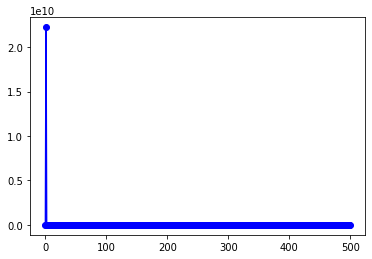

In [ ]:
# import matplotlib.pyplot as plt

# plt.plot(range(len(model_results)), [float(x) for x in model_results], 'bo-')
# plt.show()


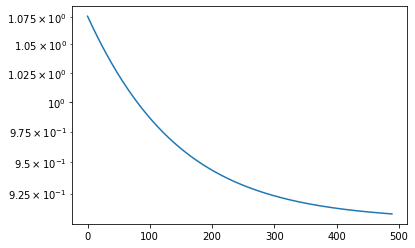

In [ ]:
# plt.plot([float(x) for x in model_results[10:]])
# plt.yscale('log')
# plt.show()
